# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server. 

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [1]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
vowels = ['a', 'e', 'i', 'o', 'u']

In [4]:
# for ratio of vowels to length of word
def vowel_count(clean_word):
    count = 0
    for i in clean_word:
        if i in vowels:
            count = count+1.0
    return count/len(clean_word)


In [5]:
f = open("words_250000_train.txt", "r")
df = []
for x in f:
  df.append(x)

In [6]:
for i in range(len(df)):
    df[i] = df[i].replace("\n", "")

In [7]:
l=[]
for words in df:
    l.append(vowel_count(words))
l = pd.Series(l)
l.describe()

count    227300.000000
mean          0.386889
std           0.095527
min           0.000000
25%           0.333333
50%           0.384615
75%           0.444444
max           1.000000
dtype: float64

(array([1.2490e+03, 2.0000e+00, 6.8100e+02, 1.7410e+03, 6.7780e+03,
        3.2538e+04, 3.5853e+04, 3.6370e+04, 6.0189e+04, 1.2807e+04,
        2.8992e+04, 7.8220e+03, 7.7600e+02, 1.1180e+03, 1.0800e+02,
        1.8300e+02, 5.4000e+01, 1.0000e+00, 0.0000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <BarContainer object of 19 artists>)

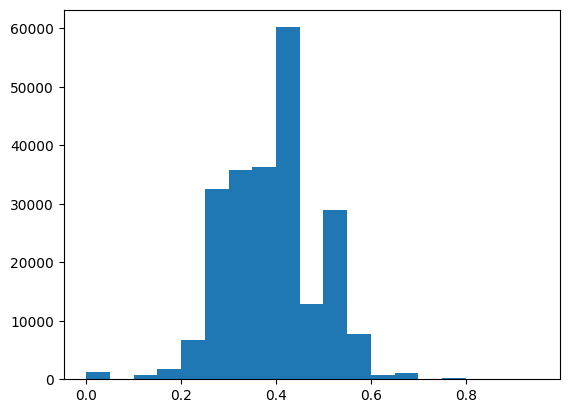

In [8]:
bins = np.arange(0.0, 1.0, 0.05)
plt.hist(x = l, bins = bins)

In [9]:
# From the above plot we can stastically say that if the number of vowels in it are greater than 0.55 times of its lenght the vowels
max_length = 0
for words in df:
    if(len(words)>max_length):
        max_length = len(words)

In [10]:
n_word_dictionary = {i:[] for i in range(3, 30)}
count = 3
while count<=max_length:
    for words in df:
        if(len(words)>=count):
            for i in range(len(words)-count+1):
                #if words[i:i+count-1] not in n_word_dictionary[count]:
                n_word_dictionary[count].append(words[i:i+count]) 
    count = count+1

In [11]:
# function to find number of times a letter come in whole dictionary, keeping count of letter 1 if it comes in a word else 0
def func(new_dictionary):
    dictx = collections.Counter()
    for words in new_dictionary:
        temp = collections.Counter(words)
        for i in temp:
            temp[i] = 1
            dictx = dictx + temp
    return dictx

In [12]:
# function to generate a list of words which are substring in the original dictionary and of same length as clean word
def func2(n_word_dictionary, clean_word):
    new_dictionary = []
    l = len(clean_word)
    for dict_word in n_word_dictionary[l]:
        if re.match(clean_word,dict_word):
            new_dictionary.append(dict_word)
    return new_dictionary

In [13]:
HANGMAN_URL = "https://www.trexsim.com/trexsim/hangman"

DNQ cell

In [ ]:
import logging

import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# import torchvision.transforms as T

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
obscured_string_len = 27

# create logger
logger = logging.getLogger('root')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


config = None


class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()       
        num_classes = 26
        num_layers = 1
        input_size = 27
        hidden_size = 32
        seq_length = 27
        
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size+26, num_classes) #fully connected 1
        # self.softmax = nn.LogSoftmax(dim=2)
        self.fc = nn.Linear(num_classes, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,word, actions):
        logger.debug("Forwad:word shape = {0}".format(word.shape))
        logger.debug("Forward:actions shape = {0}".format(actions.shape))
        logger.debug("Forward:actions = {0}".format(actions))
        logger.debug("Forward:word = {0}".format(word))
        # actions = torch.tensor(actions.reshape(-1, 26))
        # print(h_0.requires_grad)
        # Propagate input through LSTM
        # print("Forward: word req grad", word.requires_grad)
        output, (hn, cn) = self.lstm(word.float()) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        logger.debug("Forward: hn shape = {0}".format(hn.shape))
        combined = torch.cat((hn, actions), 1)
        out = self.relu(combined)
        logger.debug("Forward: combined shape = {0}".format(combined.shape))
        out = self.fc_1(out) #first Dense
        out = self.fc(out)
        logger.debug("Forward: Out = {0}".format(out))
        # out_binary = out.argmax(1)
        # print("out binary = ", out_binary)
        # final_action = torch.zeros(out.shape).scatter(1, out_binary.unsqueeze (1), 1).long()
        # print("Forward: out = ", out.numpy().tolist())
        # out = self.relu(out) #relu
        # out = self.fc(out) #Final Output
        # out = self.softmax(out)
        # print("Forward: out =", out.argmax())
        return out

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from word_lists import get_hangman_words
from collections import Counter, defaultdict
from statistics import mean
from sklearn.model_selection import train_test_split

# Function to calculate letter frequency in the word list
def calculate_letter_frequency(word_list):
    all_letters = "".join(word_list)  # Concatenating all the words
    letter_counts = Counter(all_letters)  # Count frequency of each letter
    total_letters = sum(letter_counts.values())  # Calculate total number of letters
    
    # Calculate letter frequencies and sort them
    sorted_counts = letter_counts.most_common()
    letter_frequency = {k: v / total_letters for k, v in sorted_counts}
    return letter_frequency


# Function to decide the next action (guessing a letter) based on the current state and epsilon-greedy strategy
def choose_action(state, letter_frequency, epsilon=0.1):
    global action_count
    action_count += 1  # Increase action count for each guess
    vowels = set("aeiou")
    consonants = set("bcdfghjklmnpqrstvwxyz")
    # Extract 25% of most frequent consonants
    top_consonants = [k for k, v in sorted(letter_frequency.items(), key=lambda item: item[1], reverse=True) if k in consonants][:len(consonants)//4]
    # Initialize
    if state in Q_table and np.random.rand() > epsilon:
        max_q_value = max(Q_table[state].values())
        max_actions = [action for action, q_value in Q_table[state].items() if q_value == max_q_value]
        best_action = max(max_actions, key=lambda action: letter_frequency.get(action, 0))
    else:
        remaining_letters = set("abcdefghijklmnopqrstuvwxyz") - set(state[2])
        best_action = random.choice(list(remaining_letters))
    # First two guesses should be vowels
    if action_count == 1 or action_count == 2:
        remaining_vowels = vowels - set(state[2])
        if remaining_vowels:
            best_action = random.choice(list(remaining_vowels))
    # Third and fourth should be top 25% frequent consonants
    elif action_count == 3 or action_count == 4:
        remaining_top_consonants = set(top_consonants) - set(state[2])
        if remaining_top_consonants:
            best_action = random.choice(list(remaining_top_consonants))
    return best_action


def encode_state(state, attempts_left, guessed_letters):
    return (state, attempts_left, "".join(sorted(guessed_letters)))


# Function to update the Q-table based on Q-learning algorithm
def update_Q_table(state, action, reward, new_state, Q_table, epoch, alpha_initial=0.5, decay_factor=0.01, gamma=0.9):
    alpha = alpha_initial / (1 + decay_factor * epoch)
    max_future_Q = max(Q_table[new_state].values()) if new_state in Q_table else 0
    current_Q = Q_table[state][action]

    Q_table[state][action] = (1 - alpha) * current_Q + alpha * (reward + gamma * max_future_Q)


# Hangman game logic
def hangman(word, letter_frequency, epochs):
    global action_count
    action_count = 0
    state_str = "_" * len(word)  # Initial state with underscores
    attempts_left = 6  # Number of attempts left
    guessed_letters = set()  # Letters already guessed

    state = encode_state(state_str, attempts_left, guessed_letters)
    
    history = []  # Store actions history

    while attempts_left > 0 and "_" in state_str:
        action = choose_action(state, letter_frequency)  # Choose next letter to guess
        
        guessed_letters.add(action)
        new_state_str = state_str  # Initialize new state to be same as old state initially

        # If chosen letter is in the word, reveal it
        if action in word:
            for i, c in enumerate(word):
                if c == action:
                    new_state_str = new_state_str[:i] + c + new_state_str[i+1:]
        
        else:  # Otherwise, reduce attempts
            attempts_left -= 1

        new_state = encode_state(new_state_str, attempts_left, guessed_letters)
        
        if action in word:
            reward = 0.3  # Positive reward for correct guess
        else:
            reward = -0.1  # Negative reward for wrong guess

        if "_" not in new_state_str:
            reward += 1  # Bonus reward for winning the game

        update_Q_table(state, action, reward, new_state, Q_table, epochs) # Update Q-table

        state_str = new_state_str  # Set new state as the current state
        state = new_state  # Update the entire state
        history.append(action)  # Add action to history

    return state_str, history  # Return final state and action history


def train_model(word_list, letter_frequency, epochs, epsilon_decay=0.995):
    epsilon = 1.0  # Start with a high epsilon
    win_ratio = []
    for epoch in range(epochs):
        win_count = 0
        epsilon *= epsilon_decay  # Reduce epsilon each epoch
        for word in word_list:
            result,_ = hangman(word, letter_frequency, epochs)
            if "_" not in result:  # A win if no underscores are left in the result
                win_count +=1
                win_ratio.append(win_ratio)
    return win_ratio

def evaluate_test_words(custom_words, letter_frequency):
    print("\nEvaluating on custom words:")
    wins = 0  # Number of games won
    total_games = len(custom_words)  # Total number of games    
    for word in custom_words:
        result, _ = hangman(word, letter_frequency, epochs=1)
        win = "_" not in result  # A win if no underscores are left in the result
        print(f"Word: {word}, Guess: {result} Result: {'Win' if win else 'Lose'}")
        
        if win:
            wins += 1
    win_percentage = (wins / total_games) * 100  # Calculate win percentage
    print(f"Custom Words - Wins: {wins}, Total: {total_games}, Win Percentage: {round(win_percentage, 3)}%")


# Main function to run the experiment
def run_experiment(runs):
    word_list = get_hangman_words()
    letter_frequency = calculate_letter_frequency(word_list)
    win_ratios = []
    try:
        for i in range(runs):
            print(f"Run {i + 1}: Training...")
            win_ratio = train_model(word_list, letter_frequency, epochs)
            print(f"Win ratio for run {i + 1}: {win_ratio}")

    except KeyboardInterrupt:
        print("\nExperiment interrupted. Calculating win ratio.")

    finally:
        mean_win_ratio = round(mean(win_ratios), 3)
        print(f"Mean Win Ratio: {mean_win_ratio}")

    # Custom Test Words
    test_words = ["ocean", "hangman", "rocket", "python", "cheese", "caramel", "part", "letter", "candle", "series"]
    evaluate_test_words(test_words, letter_frequency)

# Run the experiment
epochs = 40
runs = 1000
action_count = 0
word_list = get_hangman_words()
Q_table = defaultdict(lambda: defaultdict(float))
run_experiment(runs)

In [14]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)        
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        
        self.current_dictionary = []
        
    

    
        
    def guess(self, word): # word input example: "_ p p _ e "
        ###############################################
        # Replace with your own "guess" function here #
        ###############################################

        # clean the word so that we strip away the space characters
        # replace "_" with "." as "." indicates any character in regular expressions
        clean_word = word[::2].replace("_",".")
        
        # find length of passed word
        len_word = len(clean_word)
        
        # grab current dictionary of possible words from self object, initialize new possible words dictionary to empty
        current_dictionary = self.current_dictionary
        new_dictionary = []
        
        # iterate through all of the words in the old plausible dictionary
        for dict_word in current_dictionary:
            # continue if the word is not of the appropriate length
            if len(dict_word) != len_word:
                continue
                
            # if dictionary word is a possible match then add it to the current dictionary
            if re.match(clean_word,dict_word):
                new_dictionary.append(dict_word)
        
        # overwrite old possible words dictionary with updated version
        self.current_dictionary = new_dictionary
        
        '''
        # count occurrence of all characters in possible word matches
        full_dict_string = "".join(new_dictionary)
        
        c = collections.Counter(full_dict_string)
        '''
        
        c = func(new_dictionary)
        
        sorted_letter_count = c.most_common()                   
        
        guess_letter = '!'
        
        # return most frequently occurring letter in all possible words that hasn't been guessed yet
        for letter,instance_count in sorted_letter_count:
            if letter not in self.guessed_letters:
                if letter in vowels and vowel_count(clean_word)>0.55:
                    self.guessed_letters.append(letter)
                    continue
                guess_letter = letter
                break
                
        if guess_letter == '!':
            new_dictionary = func2(n_word_dictionary, clean_word)
            c = func(new_dictionary)
            sorted_letter_count = c.most_common()
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in vowels and vowel_count(clean_word)>0.55:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break
                    
                    
        if guess_letter == '!':
            x = int(len(clean_word)/2)
            if x>=3:
                c = collections.Counter()
                for i in range(len(clean_word)-x+1):
                    s = clean_word[i:i+x]
                    new_dictionary = func2(n_word_dictionary, s)
                    temp = func(new_dictionary)
                    c = c+temp
                sorted_letter_count = c.most_common()
                for letter, instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        guess_letter = letter
                        break
                    
                    
        if guess_letter == '!':
            x = int(len(clean_word)/3)
            if x>=3:
                c = collections.Counter()
                for i in range(len(clean_word)-x+1):
                    s = clean_word[i:i+x]
                    new_dictionary = func2(n_word_dictionary, s)
                    temp = func(new_dictionary)
                    c = c+temp
                sorted_letter_count = c.most_common()
                for letter, instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        guess_letter = letter
                        break
            
            
        # if no word matches in training dictionary, default back to ordering of full dictionary
        if guess_letter == '!':
            sorted_letter_count = self.full_dictionary_common_letter_sorted
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in vowels and vowel_count(clean_word)>0.55:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    break            
        
        return guess_letter

    
    


    

    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        try:
            # response = self.session.request(
            response = requests.request(
                method or "GET",
                HANGMAN_URL + path,
                timeout=self.timeout,
                params=args,
                data=post_args)
        except requests.HTTPError as e:
            response = json.loads(e.read())
            raise HangmanAPIError(response)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)
           
        
             
   

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [15]:
api = HangmanAPI(access_token="6ee4b562b9caeb8697d835f99a6d3a", timeout=2000)

## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [16]:
api.start_game(practice=1,verbose=True)
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
practice_success_rate = total_practice_successes / total_practice_runs
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))


Successfully start a new game! Game ID: 641e959a3d88. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': '641e959a3d88', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ _ _ e _ _ '}
Guessing letter: s
Sever response: {'game_id': '641e959a3d88', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ e _ _ '}
Guessing letter: n
Sever response: {'game_id': '641e959a3d88', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ _ _ _ e _ _ '}
Guessing letter: r
Sever response: {'game_id': '641e959a3d88', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ _ _ _ e _ _ '}
Guessing letter: t
Sever response: {'game_id': '641e959a3d88', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ t _ _ t e _ _ '}
Guessing letter: o
Sever response: {'game_id': '641e959a3d88', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ t _ _ t e _ o '}
Guessing letter: a
Sever response: {'game_id': '641e959a3d88', 'status': 'ong

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [17]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)
    
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
Playing  1  th game
Playing  2  th game
Playing  3  th game
Playing  4  th game
Playing  5  th game
Playing  6  th game
Playing  7  th game
Playing  8  th game
Playing  9  th game
Playing  10  th game
Playing  11  th game
Playing  12  th game
Playing  13  th game
Playing  14  th game
Playing  15  th game
Playing  16  th game
Playing  17  th game
Playing  18  th game
Playing  19  th game
Playing  20  th game
Playing  21  th game
Playing  22  th game
Playing  23  th game
Playing  24  th game
Playing  25  th game
Playing  26  th game
Playing  27  th game
Playing  28  th game
Playing  29  th game
Playing  30  th game
Playing  31  th game
Playing  32  th game
Playing  33  th game
Playing  34  th game
Playing  35  th game
Playing  36  th game
Playing  37  th game
Playing  38  th game
Playing  39  th game
Playing  40  th game
Playing  41  th game
Playing  42  th game
Playing  43  th game
Playing  44  th game
Playing  45  th game
Playing  46  th game
Playing  47  th game
Pl

ConnectTimeout: HTTPSConnectionPool(host='www.trexsim.com', port=443): Max retries exceeded with url: /trexsim/hangman/guess_letter?request=guess_letter&game_id=a58b7023c405&letter=c&access_token=6ee4b562b9caeb8697d835f99a6d3a (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001E682F6E650>, 'Connection to www.trexsim.com timed out. (connect timeout=2000)'))

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [18]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.562
